# Audio Recognition with linear classifiers

#### Let's import the libraries

In [32]:
from tensorflow import keras
import numpy as np
import tarfile
from time import time
from tensorflow.keras.applications import resnet50, vgg19, mobilenet_v2, xception, resnet
import matplotlib.pyplot as plt
import pandas as pd
import datetime, os
import pathlib
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import inception_v3
from IPython import display
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Preprocessing
#### Create train and test set

In [33]:
train_dir = "data_mel/train" 
val_dir = "data_mel/val"
test_dir = "data_mel/test"

In [34]:
species = np.array(tf.io.gfile.listdir(str(train_dir)))
species = species[species != 'README.md']
n_classes= len(species)
print('Species:', species)

Species: ['Procyon' 'Bos_taurus' 'Vulpes' 'Equus_caballus' 'Cervus_elaphus' 'Ovis'
 'Alces_alces' 'Lutra_lutra' 'Pan' 'Panthera_leo']


#### Defining imagedatagenerators

In [ ]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= resnet.preprocess_input)



train_generator = train_processing.flow_from_directory(directory = train_dir,
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 916,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1234)

x_train, y_train = next(train_generator)

Found 916 images belonging to 10 classes.


In [ ]:
val_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

val_generator = val_processing.flow_from_directory(
        directory=val_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=119,
        class_mode="categorical",
        shuffle=True
)

x_val, y_val = next(val_generator)

Found 119 images belonging to 10 classes.


In [ ]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

test_generator = test_processing.flow_from_directory(
        directory=test_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=148,
        class_mode="categorical",
        shuffle=False
)

x_test, y_test = next(test_generator)

Found 148 images belonging to 10 classes.


## Modelling
#### Import ResNet

In [ ]:
base_net = resnet.ResNet101(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3), pooling="avg")

In [ ]:
for layer in base_net.layers:
    layer.trainable = False

In [ ]:
base_net.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

It computes a cut in the **conv3_block1_2_relu** layer because there are 28\*28\*128 parameters and the memory can handle them, others lower cuts lead it to exceed out of the RAM in the linear model's fitting.

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
extractor = Model(inputs=base_net.input, outputs=base_net.get_layer('conv3_block1_2_relu').output)

## Feature extraction

Train

In [ ]:
# extract train features
conv2_block3_out_train = extractor.predict(x_train)
conv2_block3_out_train.shape

(916, 28, 28, 128)

In [ ]:
# reshape in order to have a flat vector
x_train_f = conv2_block3_out_train.reshape(916, 28*28*128)

Validation

In [ ]:
# extract features on validation
conv2_block3_out_val = extractor.predict(x_val)
conv2_block3_out_val.shape

(119, 28, 28, 128)

In [ ]:
x_val_f = conv2_block3_out_val.reshape(119, 28*28*128)

Test

In [ ]:
# extract features on test
conv2_block3_out_test = extractor.predict(x_test)
conv2_block3_out_test.shape

(148, 28, 28, 128)

In [ ]:
x_test_f = conv2_block3_out_test.reshape(148, 28*28*128)

### Save features

In [ ]:
np.save(f"{base_dir}/x_train_f.npy", x_train_f)
np.save(f"{base_dir}/x_val_f.npy", x_val_f)
np.save(f"{base_dir}/x_test_f.npy", x_test_f)

In [ ]:
np.save(f"{base_dir}/y_train.npy", y_train)
np.save(f"{base_dir}/y_val.npy", y_val)
np.save(f"{base_dir}/y_test_f.npy", y_test)

### Load features

In [35]:
x_train_f = np.load(f"{base_dir}/x_train_f.npy")
x_val_f = np.load(f"{base_dir}/x_val_f.npy")
x_test_f = np.load(f"{base_dir}/x_test_f.npy")

In [36]:
y_train = np.load(f"{base_dir}/y_train.npy")
y_val = np.load(f"{base_dir}/y_val.npy")
y_test = np.load(f"{base_dir}/y_test_f.npy")

In [37]:
y_train = np.argmax(y_train, axis = 1)
y_val = np.argmax(y_val, axis = 1)
y_test = np.argmax(y_test, axis = 1)

## SVM

In [39]:
from sklearn import svm

In [22]:
model = svm.SVC(kernel='linear', C = 1.5, class_weight = class_weight)

## Training

In [23]:
model.fit(x_train_f, y_train)

SVC(C=1.5, break_ties=False, cache_size=200,
    class_weight={0: 1.3085714285714285, 1: 0.42604651162790697,
                  2: 0.8723809523809525, 3: 1.145, 4: 0.7633333333333333,
                  5: 1.3085714285714285, 6: 1.387878787878788,
                  7: 1.3085714285714285, 8: 2.081818181818182,
                  9: 1.2052631578947368},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Results

In [24]:
# Confusion matrix
def c_matrix(y_val, y_pred, classes):
    cm = confusion_matrix(y_val, y_pred)
    fig, ax= plt.subplots(figsize = (8,6))
    sns.heatmap(cm, annot=True, annot_kws={"size": 10},
               linewidths=.2, fmt="d", cmap="PuBu")
    plt.xlabel("True Class", size = 12, horizontalalignment="right")
    plt.ylabel("Predicted Class", size = 12)
    ax.set_yticklabels(classes, rotation = 45, fontdict= {'fontsize': 10})
    ax.set_xticklabels(classes, rotation = 30, fontdict= {'fontsize': 10})
    plt.title("Confusion matrix", size = 20)
    plt.show()

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
species = ["Alces_alces", "Bos_taurus", "Cervus_elaphus", "Equus_caballus",
           "Lutra_lutra", "Ovis", "Pan", "Panthera_leo", "Procyon", "Vulpes"]

Classification Report on TEST
                precision    recall  f1-score   support

   Alces_alces       0.82      0.75      0.78        12
    Bos_taurus       0.84      0.94      0.89        33
Cervus_elaphus       0.79      0.69      0.73        16
Equus_caballus       0.69      0.79      0.73        14
   Lutra_lutra       1.00      0.94      0.97        16
          Ovis       0.85      0.92      0.88        12
           Pan       0.64      0.82      0.72        11
  Panthera_leo       1.00      0.92      0.96        12
       Procyon       0.67      0.50      0.57         8
        Vulpes       1.00      0.79      0.88        14

      accuracy                           0.83       148
     macro avg       0.83      0.80      0.81       148
  weighted avg       0.84      0.83      0.83       148



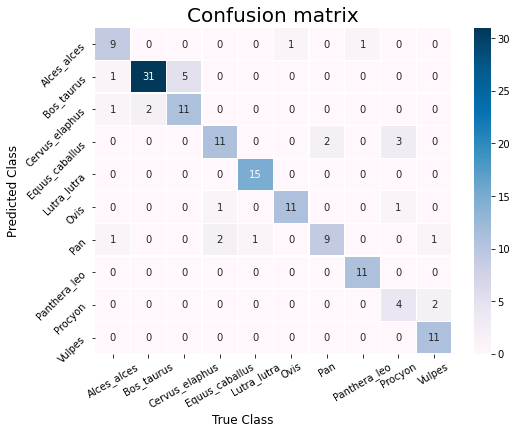

In [26]:
y_pred = model.predict(x_test_f)
print('Classification Report on TEST')
print(classification_report(y_test, y_pred, target_names=species))
c_matrix(y_pred, y_test, species)

## GridSearchCV

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]} # parametri da ottimizzare
model_grid = svm.SVC()
clf = GridSearchCV(model_grid, parameters) # definizione del modello

In [30]:
clf.fit(x_train_f, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Performance on TEST

Classification Report on TEST
                precision    recall  f1-score   support

   Alces_alces       0.82      0.75      0.78        12
    Bos_taurus       0.84      0.94      0.89        33
Cervus_elaphus       0.79      0.69      0.73        16
Equus_caballus       0.69      0.79      0.73        14
   Lutra_lutra       1.00      0.94      0.97        16
          Ovis       0.85      0.92      0.88        12
           Pan       0.64      0.82      0.72        11
  Panthera_leo       1.00      0.92      0.96        12
       Procyon       0.67      0.50      0.57         8
        Vulpes       1.00      0.79      0.88        14

      accuracy                           0.83       148
     macro avg       0.83      0.80      0.81       148
  weighted avg       0.84      0.83      0.83       148



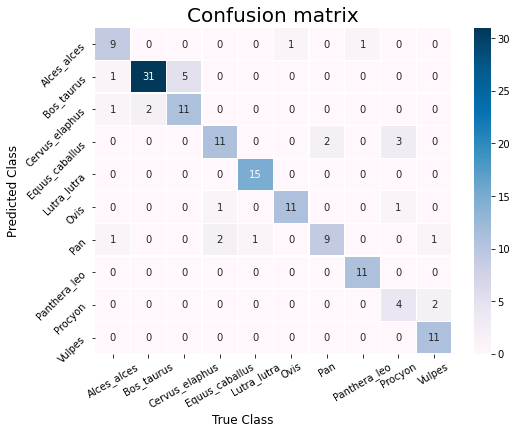

In [64]:
y_pred = clf.predict(x_test_f)
print('Classification Report on TEST')
print(classification_report(y_test, y_pred, target_names=species))
c_matrix(y_pred, y_test, species)

## Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

In [50]:
log_model = LogisticRegression(C = 1, random_state=42, max_iter = 1000)

In [51]:
log_model.fit(x_train_f, y_train)

LogisticRegression(C=1,
                   class_weight={0: 1.3085714285714285, 1: 0.42604651162790697,
                                 2: 0.8723809523809525, 3: 1.145,
                                 4: 0.7633333333333333, 5: 1.3085714285714285,
                                 6: 1.387878787878788, 7: 1.3085714285714285,
                                 8: 2.081818181818182, 9: 1.2052631578947368},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=1000, multi_class='auto',
                   n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [52]:
species = ["Alces_alces", "Bos_taurus", "Cervus_elaphus", "Equus_caballus",
           "Lutra_lutra", "Ovis", "Pan", "Panthera_leo", "Procyon", "Vulpes"]

Classification Report on TEST
                precision    recall  f1-score   support

   Alces_alces       0.90      0.75      0.82        12
    Bos_taurus       0.79      0.91      0.85        33
Cervus_elaphus       0.73      0.69      0.71        16
Equus_caballus       0.85      0.79      0.81        14
   Lutra_lutra       1.00      0.94      0.97        16
          Ovis       0.73      0.92      0.81        12
           Pan       0.73      0.73      0.73        11
  Panthera_leo       1.00      0.92      0.96        12
       Procyon       0.67      0.75      0.71         8
        Vulpes       1.00      0.79      0.88        14

      accuracy                           0.83       148
     macro avg       0.84      0.82      0.82       148
  weighted avg       0.84      0.83      0.83       148



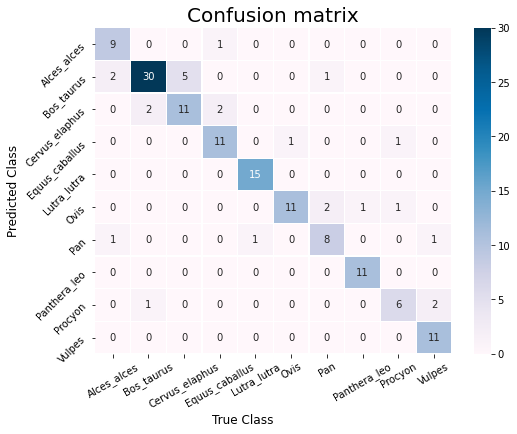

In [65]:
y_pred = log_model.predict(x_test_f)
print('Classification Report on TEST')
print(classification_report(y_test, y_pred, target_names=species))
c_matrix(y_pred, y_test, species)